### Becoming a Backprop Ninja!

Starting witht the code from `NN_v3` (The NN model with BatchNormalization), the aim is to replace `loss.backward()` with manual backpropagation calculations.

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random

%matplotlib inline

In [2]:
BLOCK_SIZE = 3
N_EMBED = 10
N_HIDDEN = 64
N_EPOCHS = 1000
BATCH_SIZE = 32
g = torch.Generator().manual_seed(2147483647)

In [3]:
def createWordsMapping(filename = '../data/names.txt'):
  words = open(filename, 'r').read().splitlines()
  chars = sorted(list(set(''.join(words))))
  stoi = {s:i+1 for i,s in enumerate(chars)}
  stoi['.'] = 0
  itos = {i:s for s,i in stoi.items()}
  n_vocab = len(stoi)
  return words, stoi, itos, n_vocab

def buildDataset(words, block_size):
  X, Y = [], []
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix]
  X = torch.tensor(X)
  Y = torch.tensor(Y)
  return X,Y

def buildDatasets(words, block_size):
  random.seed(42)
  random.shuffle(words)
  
  n1 = int(0.8 * len(words))
  n2 = int(0.9 * len(words))
  
  Xtr, Ytr = buildDataset(words[:n1], block_size)
  Xdev, Ydev = buildDataset(words[n1:n2], block_size)
  Xte, Yte = buildDataset(words[n2:], block_size)

  return Xtr, Ytr, Xdev, Ydev, Xte, Yte

In [4]:
words, stoi, itos, n_vocab = createWordsMapping()
Xtr, Ytr, Xdev, Ydev, Xte, Yte = buildDatasets(words, BLOCK_SIZE)
n_embed, n_hidden, block_size, n_epochs, batch_size = N_EMBED, N_HIDDEN, BLOCK_SIZE, N_EPOCHS, BATCH_SIZE
X, Y = Xtr, Ytr

In [5]:
# Utility function to compare gradients to PyTorch gradients
def cmp(s, dt, t):
  ex = torch.all(dt == t.grad).item()
  app = torch.allclose(dt, t.grad)
  maxdiff = (dt - t.grad).abs().max().item()
  print(f'{s:15s} | exact: {str(ex):5s} | approximate: {str(app):5s} | maxdiff: {maxdiff}')

In [6]:
C = torch.randn((n_vocab, n_embed), generator=g)

W1 = torch.randn((n_embed * block_size, n_hidden), generator=g) * ((5/3)/((n_embed*block_size) ** 0.5))
b1 = torch.randn(n_hidden, generator=g) * 0.1
W2 = torch.randn((n_hidden, n_vocab), generator=g) * 0.1
b2 = torch.randn(n_vocab, generator=g) * 0.1

bngain = torch.ones((1, n_hidden)) * 0.1 + 1.0
bnbias = torch.zeros((1, n_hidden)) * 0.1

bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, b1, bngain, bnbias, W2, b2]
static_parameters = [bnmean_running, bnstd_running]

for p in parameters:
  p.requires_grad = True

print(f'Total Parameters: {sum(p.nelement() for p in parameters)}')

Total Parameters: 4137


In [7]:
# Minibatch construct
ix = torch.randint(0, X.shape[0], (batch_size,), generator=g)
X_batch, Y_batch = X[ix], Y[ix]

In [8]:
# Forward Pass

# Get Embeddings
emb = parameters[0][X_batch] # embed characters into vectors
embcat = emb.view(emb.shape[0], -1) # concatentae the vectors

# Linear Layer 1
hprebn = embcat @ W1 + b1 # hidden layer preactivation

# Batch Normalization Layer
bnmeani = 1/batch_size * hprebn.sum(0, keepdim=True)
bndiff = hprebn - bnmeani
bndiff2 = bndiff ** 2
bnvar = 1/(batch_size-1) * (bndiff2).sum(0, keepdim=True) # Bessel's Correction: divide by (n-1), not n
bnvar_inv = (bnvar + 1e-5)**-0.5
bnraw = bndiff * bnvar_inv
hpreact = bngain * bnraw + bnbias

# Non-Linearity
h = torch.tanh(hpreact)
logits = h @ W2 + b2

# Cross Entropy Loss (Same as  F.cross_entropy(logits, Y_batch))
logit_maxes = logits.max(1, keepdim=True).values
norm_logits = logits - logit_maxes # subtract max for neumerical stability
counts = norm_logits.exp()
counts_sum = counts.sum(1, keepdims=True)
counts_sum_inv = counts_sum ** -1
probs = counts * counts_sum_inv
logprobs = probs.log()
loss = - logprobs[range(batch_size), Y_batch].mean()

# Backward Pass
for p in parameters:
  p.grad = None
for t in [logprobs, probs, counts, counts_sum, counts_sum_inv, norm_logits, logit_maxes, logits, h, hpreact, bnraw, bnvar_inv, bnvar, bndiff2, bndiff, hprebn, bnmeani, embcat, emb]:
  t.retain_grad()
loss.backward()
loss

tensor(3.3482, grad_fn=<NegBackward0>)

In [9]:
print(logprobs.shape)
print(logprobs[range(batch_size), Y_batch])
# loss = - (a+b+c+...batch_size numbers)/batch_size
# dloss/da = -1/batch_size

torch.Size([32, 27])
tensor([-4.0580, -3.0728, -3.6750, -3.2631, -4.1653, -3.5406, -3.1162, -4.0795,
        -3.2095, -4.3294, -3.1081, -1.6111, -2.8121, -2.9719, -2.9798, -3.1644,
        -3.8541, -3.0233, -3.5830, -3.3694, -2.8526, -2.9453, -4.3805, -4.0618,
        -3.5177, -2.8368, -2.9712, -3.9312, -2.7585, -3.4454, -3.3162, -3.1384],
       grad_fn=<IndexBackward0>)


In [10]:
dlogprobs = torch.zeros_like(logprobs)

dlogprobs[range(batch_size), Y_batch] = -1.0/batch_size
dprobs = (1.0/probs) * dlogprobs
dcounts_sum_inv = (counts * dprobs).sum(1, keepdim=True)
dcounts = counts_sum_inv * dprobs
dcounts_sum = (-counts_sum**-2) * dcounts_sum_inv
dcounts += torch.ones_like(counts) * dcounts_sum
dnorm_logits = (norm_logits.exp()) * dcounts
dlogits = dnorm_logits.clone()
dlogit_maxes = (-dnorm_logits).sum(1, keepdim=True)
dlogits += F.one_hot(logits.max(1).indices, num_classes=logits.shape[1]) * dlogit_maxes
dh = dlogits @ W2.T
dW2 = h.T @ dlogits
db2 = dlogits.sum(0)
dhpreact = (1.0 - h**2) * dh
dbngain = (bnraw * dhpreact).sum(0, keepdim=True)
dbnraw = (bngain * dhpreact)
dbnbias = dhpreact.sum(0, keepdim=True)
dbndiff = bnvar_inv * dbnraw
dbnvar_inv = (bndiff * dbnraw).sum(0, keepdim=True)
dbnvar = (-0.5 * (bnvar + 1e-5) ** -1.5) * dbnvar_inv
dbndiff2 = (1.0/(batch_size-1)) * torch.ones_like(bndiff2) * dbnvar
dbndiff += (2 * bndiff) * dbndiff2
dhprebn = dbndiff.clone()
dbnmeani = (-dbndiff).sum(0)
dhprebn += 1.0/batch_size * (torch.ones_like(hprebn) * dbnmeani)
dembcat = dhprebn @ W1.T
dW1 = embcat.T @ dhprebn
db1 = dhprebn.sum(0)
demb = dembcat.view(emb.shape)
dC = torch.zeros_like(C)
for k in range(X_batch.shape[0]):
  for j in range(X_batch.shape[1]):
    ix = X_batch[k,j]
    dC[ix] += demb[k,j]

cmp('logprobs', dlogprobs, logprobs)
cmp('probs', dprobs, probs)
cmp('counts_sum_inv', dcounts_sum_inv, counts_sum_inv)
cmp('counts_sum', dcounts_sum, counts_sum)
cmp('counts', dcounts, counts)
cmp('norm_logits', dnorm_logits, norm_logits)
cmp('logit_maxes', dlogit_maxes, logit_maxes)
cmp('logits', dlogits, logits)
cmp('h', dh, h)
cmp('W2', dW2, W2)
cmp('b2', db2, b2)
cmp('hpreact', dhpreact, hpreact)
cmp('bngain', dbngain, bngain)
cmp('bnbias', dbnbias, bnbias)
cmp('bnraw', dbnraw, bnraw)
cmp('bnvar_inv', dbnvar_inv, bnvar_inv)
cmp('bnvar', dbnvar, bnvar)
cmp('bndiff2', dbndiff2, bndiff2)
cmp('bndiff', dbndiff, bndiff)
cmp('bnmeani', dbnmeani, bnmeani)
cmp('hprebn', dhprebn, hprebn)
cmp('embcat', dembcat, embcat)
cmp('W1', dW1, W1)
cmp('b1', db1, b1)
cmp('emb', demb, emb)
cmp('C', dC, C)

logprobs        | exact: True  | approximate: True  | maxdiff: 0.0
probs           | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum_inv  | exact: True  | approximate: True  | maxdiff: 0.0
counts_sum      | exact: True  | approximate: True  | maxdiff: 0.0
counts          | exact: True  | approximate: True  | maxdiff: 0.0
norm_logits     | exact: True  | approximate: True  | maxdiff: 0.0
logit_maxes     | exact: True  | approximate: True  | maxdiff: 0.0
logits          | exact: True  | approximate: True  | maxdiff: 0.0
h               | exact: True  | approximate: True  | maxdiff: 0.0
W2              | exact: True  | approximate: True  | maxdiff: 0.0
b2              | exact: True  | approximate: True  | maxdiff: 0.0
hpreact         | exact: True  | approximate: True  | maxdiff: 0.0
bngain          | exact: True  | approximate: True  | maxdiff: 0.0
bnbias          | exact: True  | approximate: True  | maxdiff: 0.0
bnraw           | exact: True  | approximate: True  | maxdiff:

In [16]:
# Exercise 2: backprop through cross_entropy but all in one go

loss_fast = F.cross_entropy(logits, Y_batch)
print(loss_fast.item(), 'diff:', (loss_fast - loss).item())

3.348198175430298 diff: 0.0


In [12]:
# Backward Pass

dlogits = F.softmax(logits, 1)
dlogits[range(batch_size), Y_batch] -= 1
dlogits /= batch_size

cmp('logits', dlogits, logits)

logits          | exact: False | approximate: True  | maxdiff: 7.683411240577698e-09


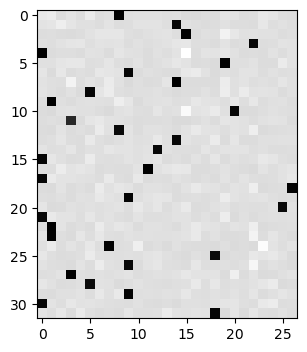

In [13]:
plt.figure(figsize=(4, 4))
plt.imshow(dlogits.detach(), cmap='gray')

In [15]:
# Exercise 3: backprop through batchnorm but all in one go

hpreact_fast = bngain * (hprebn - hprebn.mean(0, keepdim=True)) / torch.sqrt(hprebn.var(0, keepdim=True, unbiased=True) + 1e-5) + bnbias
print('max diff:', (hpreact_fast - hpreact).abs().max())

max diff: tensor(4.7684e-07, grad_fn=<MaxBackward1>)


In [18]:
dhprebn = bngain*bnvar_inv/batch_size * (batch_size*dhpreact - dhpreact.sum(0) - batch_size/(batch_size-1)*bnraw*(dhpreact*bnraw).sum(0))

cmp('hprebn', dhprebn, hprebn)

hprebn          | exact: False | approximate: True  | maxdiff: 9.313225746154785e-10
